In [1]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
from matplotlib.colors import LogNorm

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

############ Set up paths #############
SAVEPLOT = True

MIN_CAUSAL_SCORE = 0.17


############ Load data #############
allstrs = pd.read_csv(os.path.join(DATADIR, "misc", "all_analyzed_strs.tab"), sep="\t")
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"
dnaseI = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "dnasehs_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.dnase"])

# All ref data
ref = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "hg19.hipstr_reference_annot.bed"), sep="\t")
ref["str.start"]=ref["start"]
ref = pd.merge(ref, allstrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])

# TF ref data
ref_tf = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "hg19.hipstr_reference_tfbs.bed"), sep="\t")
ref_tf["str.start"] = ref_tf["start"]
ref_tf = pd.merge(ref_tf, allstrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])

# Gene annot
geneannot = pd.read_csv(GENEANNOT)

# CAVIAR table
estrs = pd.read_csv(os.path.join(RESULTSDIR, "SuppTable_CAVIAR.tsv"), sep="\t")
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene","gene.strand"]], on=["gene"])
estrs["motif"] = estrs.apply(lambda x: x["str.motif.forward"] if x["gene.strand"]=="+" else x["str.motif.reverse"], 1)

# All data
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}
TISSUES = [item for item in list(COLORS.keys()) if item != "permuted"]

master = {} # Map of tissue -> data
for t in TISSUES:
    d = pd.read_csv(os.path.join(DATADIR, "mastertables", "%s_master.tab"%t), sep="\t", 
                            usecols=["chrom","gene","gene.name","str.start","linreg.beta","linreg.pval", 
                                     "linreg.significant",
                                     "anova.pval","caviar.str.score","caviar.str.rank", "caviar.topsnp.score",
                                     "mashr.significant"])
    d["gene"] = d["gene"].apply(lambda x: x.split(".")[0])
    d["signif_%s"%t] = d["linreg.significant"]
    master[t] =  d 

Populating the interactive namespace from numpy and matplotlib


In [74]:
CAUSAL_COLOR = "black"
ESTR_COLOR = "gray"

def NormTable(t, total):
    x = t[0][0]+t[0][1]+t[1][0]
    t[1][1] = total-x
    return t

def GetEnrichCI(table, numsim=0):
    mult = 1 # +/- 1 stderr
    odds, pval = scipy.stats.fisher_exact(table)
    try:
        se_logOR = np.sqrt(1.0/table[0][0]+1.0/table[0][1]+1.0/table[1][0]+1.0/table[1][1])
        odds2 = table[0][0]*table[1][1]/(table[0][1]*table[1][0])
        odds_l = np.exp(np.log(odds2)-mult*se_logOR)
        odds_h = np.exp(np.log(odds2)+mult*se_logOR)
    except:
        odds2 = np.nan
        odds_l = np.nan
        odds_h = np.nan
    print("%s (%s-%s)"%(odds2, odds_l, odds_h))
    return odds, pval, odds_l, odds_h

def GetEnrichments(ref, estrs, causal, annotations, annot_col=True, numsim=0):
    """
    Return data frame with estr and causal enrichments for all annotations
    if annot_col, use "annot" column. else use annotation os the column itself
    """
    num_total = []
    num_estrs = []
    pval_estrs = []
    odds_estrs = []
    num_causal = []
    pval_causal = []
    odds_causal = []
    odds_causal_low = []
    odds_causal_high = []
    
    dir_estrs = []
    pval_dir_estrs = []
    dir_causal = []
    pval_dir_causal = []
    
    estrs_annot = estrs.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})
    causal_annot = causal.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})

    estrs_annot = pd.merge(estrs_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    causal_annot = pd.merge(causal_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    
    num_total_ref = ref.shape[0]
    num_total_estr = estrs_annot.shape[0]
    num_total_causal = causal_annot.shape[0]
    
    for annot in annotations:
        if annot_col:
            num_annot_ref = ref[ref["annot"]==annot].shape[0]
            num_annot_estr = estrs_annot[estrs_annot["annot"]==annot].shape[0]
            num_annot_causal = causal_annot[causal_annot["annot"]==annot].shape[0]
        else:
            num_annot_ref = ref[ref[annot]>0].shape[0]
            num_annot_estr = estrs_annot[estrs_annot[annot]>0].shape[0]
            num_annot_causal = causal_annot[causal_annot[annot]>0].shape[0]
        # Test estrs
        t_estr = NormTable([[num_annot_estr, num_total_estr-num_annot_estr], [num_annot_ref-num_annot_estr, 0]], num_total_ref)
        o_estr, p_estr = scipy.stats.fisher_exact(t_estr)
        # Test causal
        t_causal = NormTable([[num_annot_causal, num_total_causal-num_annot_causal], [num_annot_ref-num_annot_causal, 0]], num_total_ref)
        o_causal, p_causal, o_causal_L, o_causal_H = GetEnrichCI(t_causal, numsim=numsim)
        # Direction
        if annot_col:
            num_pos_estr = sum(estrs_annot[estrs_annot["annot"]==annot]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot["annot"]==annot]["beta"]>0)
        else:
            num_pos_estr = sum(estrs_annot[estrs_annot[annot]>0]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot[annot]>0]["beta"]>0)
        dir_estrs.append(num_pos_estr*1.0/num_annot_estr)
        dir_causal.append(num_pos_causal*1.0/num_annot_causal)                            
        pval_dir_estrs.append(scipy.stats.binom_test(num_pos_estr, num_annot_estr))
        pval_dir_causal.append(scipy.stats.binom_test(num_pos_causal, num_annot_causal))
        # Add to data
        num_total.append(num_annot_ref)
        num_estrs.append(num_annot_estr)
        num_causal.append(num_annot_causal)
        odds_estrs.append(o_estr)
        pval_estrs.append(p_estr)
        odds_causal.append(o_causal)
        odds_causal_low.append(o_causal_L)
        odds_causal_high.append(o_causal_H)
        pval_causal.append(p_causal)
        
    annotenrich = pd.DataFrame({
        "annot": annotations,
        "num.total": num_total,
        "num.estrs": num_estrs,
        "num.causal": num_causal,
        "pval.estrs": pval_estrs,
        "odds.estrs": odds_estrs,
        "pval.causal": pval_causal,
        "odds.causal": odds_causal,
        "odds.causal.low": odds_causal_low,
        "odds.causal.high": odds_causal_high,
        "dir.estrs": dir_estrs,
        "p.dir.estrs": pval_dir_estrs,
        "dir.causal": dir_causal,
        "p.dir.causal": pval_dir_causal
    })
    return annotenrich

def maxabs(x):
    abs_x = [abs(item) for item in x]
    return list(x)[abs_x.index(max(abs_x))]

def OutputEnrichmentTable(enrich, fname):
    cols = ["annot","num.total","num.estrs","num.causal"] + \
        ["pval.estrs","odds.estrs", "pval.causal","odds.causal"]
    enrich.sort_values("odds.causal", ascending=False)[cols].to_csv(fname, index=False)


In [75]:
all_annot = ["coding", "5utr", "3utr", "introns", "hg19_promoter_3kb"]

annotenrich_by_cutoff = []
#cutoffs = list(np.arange(0, 0.91, 0.05))+[MIN_CAUSAL_SCORE]
percentiles = np.arange(0, 105, 5)
cutoffs = [round(item, 2) for item in np.percentile(estrs[~np.isnan(estrs["score"])]["score"], percentiles)]
percall = []

prev_cutoff = -1
res = None
for cutoff in cutoffs:
    print(cutoff)
    if cutoff == prev_cutoff:
        annotenrich_by_cutoff.append(res)
        continue
    c = estrs[estrs["score"]>=cutoff]
    percall.append(c.shape[0]*1.0/estrs.shape[0])
    res = GetEnrichments(ref, estrs, c, all_annot, annot_col=False)
    annotenrich_by_cutoff.append(res)
    prev_cutoff = cutoff
#annotenrich_by_cutoff[list(cutoffs).index(MIN_CAUSAL_SCORE)]

0.0
2.898306930291009 (2.510903579970788-3.3454821320819574)
2.2979860830281926 (2.1106975120976976-2.501893335034559)
2.213605063920364 (2.1009414685737906-2.3323102772302557)
1.134466078111968 (1.1173401686126316-1.1518544831202089)
2.4983406748197456 (2.432005574755723-2.566485123326954)
0.0
0.0
0.01
3.1549946762792964 (2.7213706656734415-3.657712465599553)
2.5486525395757353 (2.3333468738119016-2.7838251742117444)
2.2861154013730576 (2.163227004836435-2.4159848303993723)
1.1143719209888165 (1.0957768455307806-1.1332825505057835)
2.574542444300161 (2.5022085437187993-2.6489673748983655)
0.01
0.01
0.01
0.01
0.02
3.156175823405571 (2.7002700476208537-3.6890554102270756)
2.675093999353489 (2.4371988817407795-2.9362100725508906)
2.3616122012695966 (2.226529609162552-2.50489019604062)
1.0795805294159504 (1.0596521955078346-1.0998836452516052)
2.679346098698256 (2.59915531184197-2.7620109825303296)
0.02
0.02
0.03
3.156401840308904 (2.675984054893401-3.723068737755357)
3.0066329366654942 (

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


1.239628468066961 (0.6623256527372471-2.3201256549422227)
1.735861049519586 (0.6081219733849584-4.954949360679965)


In [63]:
annotenrich_by_cutoff[list(cutoffs).index(0.3)]

,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.causal.high,odds.causal.low,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs
0,coding,0.454545,0.475000,11,80,206,5.053106,9.297413,2.746343,2.950760,1.000000,0.737554,2.318370e-05,1.367073e-12
1,5utr,0.575758,0.502392,33,209,631,5.007482,7.138501,3.512625,2.308584,0.486850,1.000000,4.890502e-13,1.290295e-20
2,3utr,0.529412,0.473779,51,553,1721,2.784051,3.697723,2.096139,2.225856,0.779768,0.233749,5.853420e-10,8.312145e-48
3,introns,0.498132,0.499033,803,13446,72706,0.985633,1.097568,0.885114,1.133304,0.943739,0.829303,8.047211e-01,1.512812e-16
4,hg19_promoter_3kb,0.547511,0.489661,221,2273,6766,3.387753,3.920313,2.927539,2.500233,0.178382,0.334623,1.100827e-46,1.267647e-229


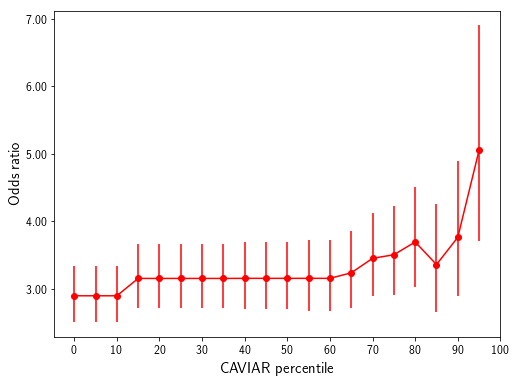

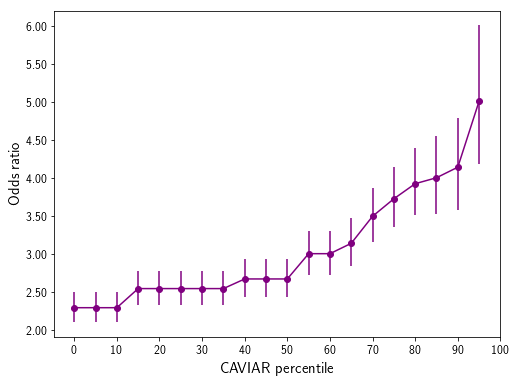

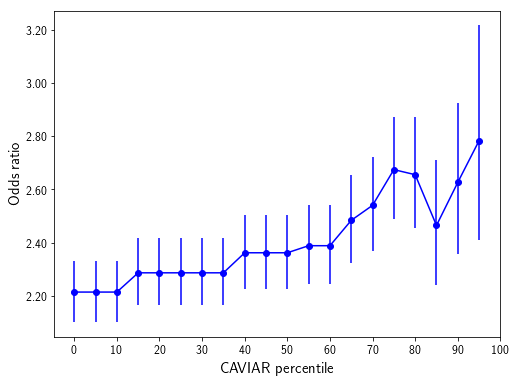

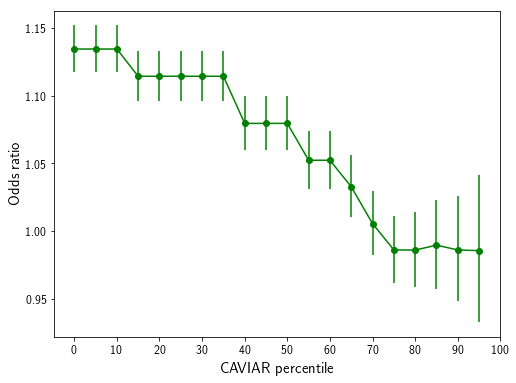

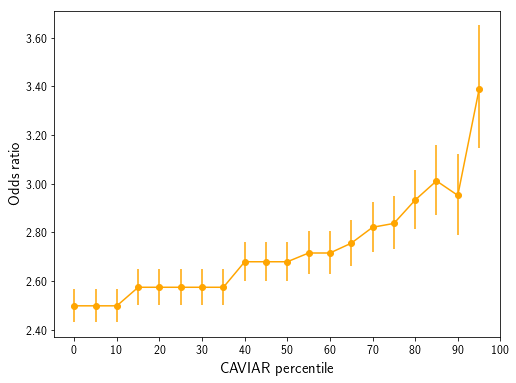

In [80]:
annot_colors = {
    "coding": "red",
    "introns": "green",
    "5utr": "purple",
    "3utr": "blue",
    "hg19_promoter_3kb": "orange",
    "cabili_lincrnas_ucsc": "gold"
}
percentiles_ax = list(percentiles)[:-1]



for j in range(len(all_annot)):
    fig = plt.figure()
    fig.set_size_inches((8, 6))
    ax = fig.add_subplot(111)
    causal_enrich = ([annotenrich_by_cutoff[i]["odds.causal"].values[j] for i in range(len(percentiles_ax))])
    estr_enrich = ([annotenrich_by_cutoff[i]["odds.estrs"].values[j] for i in range(len(percentiles_ax))])
    causal_errs_low = [causal_enrich[i]-annotenrich_by_cutoff[i]["odds.causal.low"].values[j] for i in range(len(percentiles_ax))]
    causal_errs_high = [annotenrich_by_cutoff[i]["odds.causal.high"].values[j]-causal_enrich[i] for i in range(len(percentiles_ax))]
    color = annot_colors[all_annot[j]]
    #ax.plot(percentiles_ax, causal_enrich, label=all_annot[j].replace("_",""), color=color)
    ax.errorbar(percentiles_ax, causal_enrich, yerr=(causal_errs_low, causal_errs_high), 
                label=all_annot[j].replace("_",""), color=color, marker="o")
    #ax.plot(percentiles_ax, estr_enrich, linestyle="dashed", color=color)
    #ax.axhline(y=0, color="black")
#ax.legend(loc="lower right");
    ax.set_xlabel("CAVIAR percentile", size=15)
    ax.set_ylabel("Odds ratio", size=15)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=12)
    ax.set_yticklabels(["%.2f"% item for item in ax.get_yticks()], size=12);
    if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_CAVSCORE_%s.pdf"%all_annot[j]))
#ax.axvline(x=90, color="black", linestyle="dashed")

#if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_CAVSCORE_A.pdf"))

#fig = plt.figure()
#fig.set_size_inches((8, 2))
#ax = fig.add_subplot(111)
#ax.plot(cutoffs, [(item*estrs.shape[0]) for item in percall], color="black")
#ax.set_xlabel("CAVIAR score", size=15)
#ax.set_ylabel("Num. eSTRs", size=15)
#ax.set_xticklabels(["%.2f"% item for item in ax.get_xticks()], size=12)
#ax.set_yticklabels([int(item) for item in ax.get_yticks()], size=12);
#ax.axhline(y=estrs.shape[0]*percall[list(cutoffs).index(MIN_CAUSAL_SCORE)], linestyle="dashed")
#ax.axvline(x=MIN_CAUSAL_SCORE, linestyle="dashed")
#print(percall[list(cutoffs).index(MIN_CAUSAL_SCORE)])
#if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_CAVSCORE_B.pdf"))

In [ ]:
# Table of coding eSTRs
coding_causal = pd.merge(estrs[estrs["score"]>=MIN_CAUSAL_SCORE], ref[ref["coding"]>0][["chrom","str.start"]], on=["chrom","str.start"])[["chrom","str.start","gene.name","str.motif.forward","score","tissue_info"]]
coding_causal.sort_values("score", ascending=False)

In [ ]:
# TF Enrichment
tf_annot = [item for item in ref_tf.columns if item not in ["chrom","start","end","period","motif","str.start"]]
tf_enrich = GetEnrichments(ref_tf, estrs, estrs[estrs["score"]>=MIN_CAUSAL_SCORE], tf_annot, annot_col=False)
tf_enrich = tf_enrich[tf_enrich["num.causal"]>=3].sort_values("odds.causal", ascending=False)
tf_enrich["signif"] = tf_enrich["pval.causal"]<=0.05/tf_enrich.shape[0]
tf_enrich.sort_values("odds.causal", ascending=False)
OutputEnrichmentTable(tf_enrich, os.path.join(RESULTSDIR, "SuppTable_TFEnrich.csv"))

In [ ]:
# Direction of effect
causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

print("all estrs")
print(sum(estrs["beta"]>0)*1.0/estrs.shape[0])
print(scipy.stats.binom_test(sum(estrs["beta"]>0), estrs.shape[0]))
print("causal estrs")
print(sum(causal["beta"]>0)*1.0/causal.shape[0])
print(scipy.stats.binom_test(sum(causal["beta"]>0), causal.shape[0]))

In [ ]:
# TSS Localization
geneannot["gene"] = geneannot["gene.id"]
HIPREF="/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed"
hipref = pd.read_csv(HIPREF, sep="\t", names=["chrom","str.start","str.end","period","str.motif.forward","str.motif.reverse"])

all_str_genes = pd.merge(allstrs, geneannot[["gene","gene.start","gene.stop","gene.strand"]], on=["gene"])
all_str_genes["gene"] = all_str_genes["gene"].apply(lambda x: x.split(".")[0])
all_str_genes = pd.merge(all_str_genes, hipref[["chrom","str.start","str.motif.forward","str.motif.reverse"]], on=["chrom","str.start"])
all_str_genes["motif"] = all_str_genes.apply(lambda x: x["str.motif.forward"] if x["gene.strand"]=="+" else x["str.motif.reverse"], 1)
all_str_genes["dist.tss"] = all_str_genes.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)
all_str_genes["dist.tes"] = all_str_genes.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="-" else (x["gene.stop"]-x["str.start"]), 1)
all_str_genes = pd.merge(all_str_genes, dnaseI[["chrom","str.start","dist.dnase"]], on=["chrom","str.start"])

In [ ]:

default_bins = np.arange(-50000, 50000, 1000)

def ProcessData(all_str_genes, estrs, causal, col, bins=default_bins, useabs=False):
    #keys = ["ALL","AC","GT","CG","AT","AG","CT","A","T"]
    all_motifs = set(all_str_genes["motif"])
    othermotifs = {
        "AC": ["AC"],
        "GT": ["GT"],
        "AG": ["AG"],
        "CT": ["CT"],
        "CG": ["CG","CCG","CCCG","CCCCG","CCCCCG","CCCCGG"],
        "GC": ["CG", "CGG", "CGGG", "CGGGG", "CGGGGG", "CCGGGG"],
        "AT": ["AT"],
        "AG": ["AG"],
        "AGG": ["AGG"],
        "A": ["A"],
        "T": ["T"],
        "2": [item for item in all_motifs if len(item)==2],
        "1": [item for item in all_motifs if len(item)==1],
        "5": [item for item in all_motifs if len(item)==5],
        "6": [item for item in all_motifs if len(item)==6],
        "4": [item for item in all_motifs if len(item)==4],
        "3": [item for item in all_motifs if len(item)==3],
        "ALL": all_motifs
    }
    keys = othermotifs.keys()
    num = {}
    p = {}
    p_causal = {}
    
    num_total = all_str_genes[["chrom","str.start"]].drop_duplicates().shape[0]
    num_estrs = estrs[["chrom","str.start"]].drop_duplicates().shape[0]
    num_causal = causal[["chrom","str.start"]].drop_duplicates().shape[0]
    p_avg = num_estrs*1.0/num_total
    p_causal_avg = num_causal*1.0/num_total
    
    # Get bindata
    for key in keys:
        num[key] = []
        p[key] = []
        p_causal[key] = []
        
        all_motif_data = all_str_genes[all_str_genes["motif"].apply(lambda x: x in othermotifs[key], 1)].copy()
        estr_motif_data = estrs[estrs["motif"].apply(lambda x: x in othermotifs[key], 1)].copy()
        causal_motif_data = causal[causal["motif"].apply(lambda x: x in othermotifs[key], 1)].copy()
        
        estr_motif_data = pd.merge(all_motif_data, estr_motif_data[["chrom","str.start","gene"]], on=["chrom","str.start","gene"])
        causal_motif_data = pd.merge(all_motif_data, causal_motif_data[["chrom","str.start","gene"]], on=["chrom","str.start","gene"])
        
        for i in range(len(bins)-1):
            lb = bins[i]
            ub = bins[i+1]
            if not useabs:
                x_all = all_motif_data[(all_motif_data[col]>=lb) & (all_motif_data[col]<ub)][["chrom","str.start"]].drop_duplicates().shape[0]
                x_estr = estr_motif_data[(estr_motif_data[col]>=lb) & (estr_motif_data[col]<ub)][["chrom","str.start"]].drop_duplicates().shape[0]
                x_causal = causal_motif_data[(causal_motif_data[col]>=lb) & (causal_motif_data[col]<ub)][["chrom","str.start"]].drop_duplicates().shape[0]
            else:
                nlb = abs(lb)
                nub = abs(ub)
                if nub<nlb:
                    nlb = abs(ub)
                    nub = abs(lb)
                x_all = all_motif_data[(all_motif_data[col].apply(abs)>=nlb) & (all_motif_data[col].apply(abs)<nub)][["chrom","str.start"]].drop_duplicates().shape[0]
                x_estr = estr_motif_data[(estr_motif_data[col].apply(abs)>=nlb) & (estr_motif_data[col].apply(abs)<nub)][["chrom","str.start"]].drop_duplicates().shape[0]
                x_causal = causal_motif_data[(causal_motif_data[col].apply(abs)>=nlb) & (causal_motif_data[col].apply(abs)<nub)][["chrom","str.start"]].drop_duplicates().shape[0]
                #print("%s %s %s"%(x_all, nlb, nub))
            if x_all == 0:
                num[key].append(0)
                p[key].append(float("nan"))
                p_causal[key].append(float("nan"))
            else:
                num[key].append(x_all*1.0/all_motif_data.shape[0])
                p[key].append(x_estr*1.0/x_all)
                p_causal[key].append(x_causal*1.0/x_all)
    return num, p, p_causal, p_avg, p_causal_avg

def Smooth(x, buf=2, avg=None, norm=False):
    if avg is not None:
        x = [item*1.0/avg for item in x]
    if norm:
        m = np.mean(x)
        x = [item*1.0/m for item in x]
    newx = []
    for i in range(len(x)):
        l = max([0, i-buf])
        u = min([len(x), i+buf])
        newx.append(np.mean(x[l:u]))
    return newx

def PlotPosition(num, p, p_causal, p_avg, pcausal_avg, bins=default_bins, buf=2, col=None, RESULTSDIR=None):
    colors = {
    "ALL": ("black", "solid"),
    "A": ("gray", "solid"),
    "T": ("gray", "dashed"),
    "AC": ("red", "solid"),
        "GT": ("red", "dashed"),
        "AT": ("maroon", "solid"),
        "1": ("gray", "solid"),
        "2": ("red", "solid"),
        "3": ("gold", "solid"),
        "4": ("blue", "solid"),
        "5": ("green", "solid"),
        "6": ("purple", "solid"),
        "CG": ("darkgreen", "solid"),
        "GC": ("darkgreen", "dashed")
    }
    size = ((10, 4))
    usekeys = colors.keys()
    
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = fig.add_subplot(111)
    keys = ["1","2","4","3","5","6", "ALL"]
    for key in keys:
        if key == "ALL": w = 1.5
        else: w = 0.5
        ax.plot(bins[:-1], (Smooth(num[key], buf=buf)), color=colors[key][0], linestyle=colors[key][1], linewidth=w, label=key)
    ax.set_ylabel("Relative abundance", size=12)
    ax.legend(loc="lower left")
    if RESULTSDIR is not None: fig.savefig(os.path.join(RESULTSDIR, "Figure2_%s_num.pdf"%col))
    
    # For supplement, plot strand diffs
    for mp in [("AC","GT"), ("A","T"), ("CG","GC")]:
        fig = plt.figure()
        fig.set_size_inches(size)
        ax2 = fig.add_subplot(111)
        for key in mp:
            ax2.plot(bins[:-1], (Smooth(num[key], buf=buf)), color=colors[key][0], linestyle=colors[key][1], linewidth=w, label=key)
            ax2.set_ylabel("Relative abundance", size=12)
        ax2.legend(loc="lower left")
        if RESULTSDIR is not None: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_%s_num_%s.pdf"%(col, mp[0])))

    fig = plt.figure()
    fig.set_size_inches(size)
    ax = fig.add_subplot(111)
    for key in ["ALL"]:
        if key == "ALL": w = 1.5
        else: w = 0.5
        ax.plot(bins[:-1], (Smooth(p[key], avg=p_avg, buf=buf)), color=ESTR_COLOR, linewidth=w, label=key)
        ax.plot(bins[:-1], (Smooth(p_causal[key], avg=p_causal_avg, buf=buf)), color=CAUSAL_COLOR, linewidth=w, label=key)
    ax.set_ylabel("P(eSTR)", size=12)
    if RESULTSDIR is not None: fig.savefig(os.path.join(RESULTSDIR, "Figure2_%s_peSTR.pdf"%col))

bins = np.arange(-10000, 10000, 100)
num, p, p_causal, p_avg, p_causal_avg = ProcessData(all_str_genes, estrs, estrs[estrs["score"]>=MIN_CAUSAL_SCORE], "dist.tss", bins=bins)
PlotPosition(num, p, p_causal, p_avg, p_causal_avg, bins=bins, buf=2, col="dist.tss", RESULTSDIR=RESULTSDIR)

In [ ]:
bins = np.arange(-5000, 5000, 50)
num, p, p_causal, p_avg, p_causal_avg = ProcessData(all_str_genes, estrs, estrs[estrs["score"]>=MIN_CAUSAL_SCORE], "dist.dnase", bins=bins, useabs=True)
PlotPosition(num, p, p_causal, p_avg, p_causal_avg, bins=bins, buf=2, col="dist.dnase", RESULTSDIR=RESULTSDIR)

In [ ]:
# Break down of period lengths in causal FM-eSTRs
causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]
for period in range(1, 7):
    print(period)
    print(causal[causal["motif"].apply(len)==period].shape[0]*1.0/causal.shape[0])